Forcasting in Engineering und Management

In [441]:
# ----------------------------------------
# Forecasting in Engineering & Management
# Main Notebook: FoEM_Projekt.ipynb
# Cleaned for S&P 500 only with TRAIN/TEST support
# ----------------------------------------

# Core packages
import pandas as pd
import numpy as np
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Statistical tools
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.tseries.offsets import BDay
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from prophet import Prophet
from prophet.make_holidays import make_holidays_df
from prophet.plot import plot_plotly


# ML/DL Tools
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Utilities
import os
import warnings
warnings.filterwarnings("ignore")
import logging
from datetime import timedelta

# Logging setup
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [442]:
# ----------------------------------------
# 🔧 Step 0: GLOBAL CONFIGURATION
# ----------------------------------------

# Forecasting Settings
HISTORY_YEARS = 5               # How many years of historical data to use
FORECAST_DAYS = 261              # Flexible forecast horizon (used in models only)
TRAIN_TEST_SPLIT = 0.8          # Keep test set stable (20% of historical data)

# Ticker & Environment
TICKER = "^GSPC"                # S&P 500 Index
SEED = 42                       # For reproducibility

In [443]:
# ----------------------------------------
# Step 1: LOAD & CLEAN TIME SERIES DATA
# ----------------------------------------

# Define date range
end_date = dt.datetime.today()
start_date = end_date - timedelta(days=HISTORY_YEARS * 365)

# Fetch S&P 500 data
logging.info(f"Downloading S&P 500 data from {start_date.date()} to {end_date.date()}...")
sp500 = yf.download(TICKER, start=start_date, end=end_date, progress=False, auto_adjust=False)

# Check if MultiIndex is present (older yfinance versions)
print("\n Raw Columns from yfinance:", sp500.columns.tolist())
if isinstance(sp500.columns, pd.MultiIndex):
    sp500.columns = [col[0] for col in sp500.columns]

# Select relevant columns
expected_cols = ['Close', 'Open', 'High', 'Low', 'Volume']
sp500 = sp500[[col for col in expected_cols if col in sp500.columns]].copy()

# Clean index and fill missing values
sp500.index = pd.to_datetime(sp500.index)
sp500 = sp500.asfreq('B')
sp500 = sp500.ffill()

# Data summary
print(f"\n Dataset Shape: {sp500.shape}")
print(f"  Time Range : {sp500.index.min().date()} → {sp500.index.max().date()}")
print(" Columns     :", ', '.join(map(str, sp500.columns)))
print("\n Missing Values:")
print(sp500.isna().sum())
print("\nℹ Use HISTORY_YEARS in config to adjust data range.")


2025-06-15 19:56:18,422 - INFO - Downloading S&P 500 data from 2020-06-16 to 2025-06-15...



 Raw Columns from yfinance: [('Adj Close', '^GSPC'), ('Close', '^GSPC'), ('High', '^GSPC'), ('Low', '^GSPC'), ('Open', '^GSPC'), ('Volume', '^GSPC')]

 Dataset Shape: (1304, 5)
  Time Range : 2020-06-16 → 2025-06-13
 Columns     : Close, Open, High, Low, Volume

 Missing Values:
Close     0
Open      0
High      0
Low       0
Volume    0
dtype: int64

ℹ Use HISTORY_YEARS in config to adjust data range.


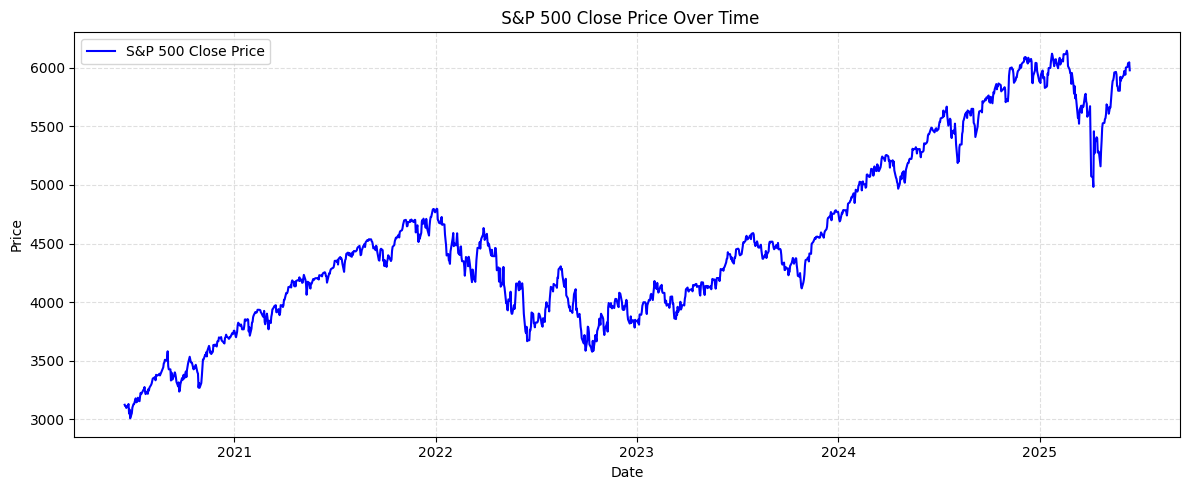

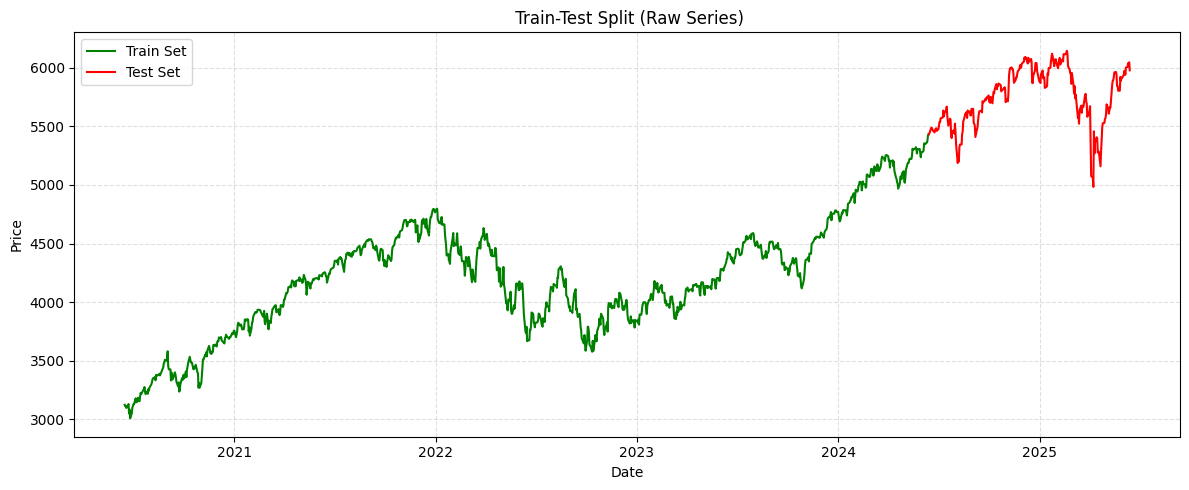

 Training samples: 1043
 Testing samples : 261
 Train Range     : 2020-06-16 → 2024-06-13
 Test Range      : 2024-06-14 → 2025-06-13


In [444]:
# ----------------------------------------
# Step 2: VISUALIZE & SPLIT TIME SERIES (Raw)
# ----------------------------------------

#  Use 'Close' price as the main target
ts_full = sp500['Close'].copy()
ts_raw = ts_full.copy()  #  Keep a clean version for global use (used later for decomposition, Prophet etc.)

# Plot full raw series
plt.figure(figsize=(12, 5))
plt.plot(ts_full, label='S&P 500 Close Price', color='blue')
plt.title(" S&P 500 Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

#  Split 80/20 for forecasting
split_index = int(len(ts_full) * TRAIN_TEST_SPLIT)
ts_train_raw = ts_full[:split_index]
ts_test_raw  = ts_full[split_index:]

#  Visualize split
plt.figure(figsize=(12, 5))
plt.plot(ts_train_raw, label='Train Set', color='green')
plt.plot(ts_test_raw, label='Test Set', color='red')
plt.title(" Train-Test Split (Raw Series)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

#  Summary
print(f" Training samples: {len(ts_train_raw)}")
print(f" Testing samples : {len(ts_test_raw)}")
print(f" Train Range     : {ts_train_raw.index.min().date()} → {ts_train_raw.index.max().date()}")
print(f" Test Range      : {ts_test_raw.index.min().date()} → {ts_test_raw.index.max().date()}")


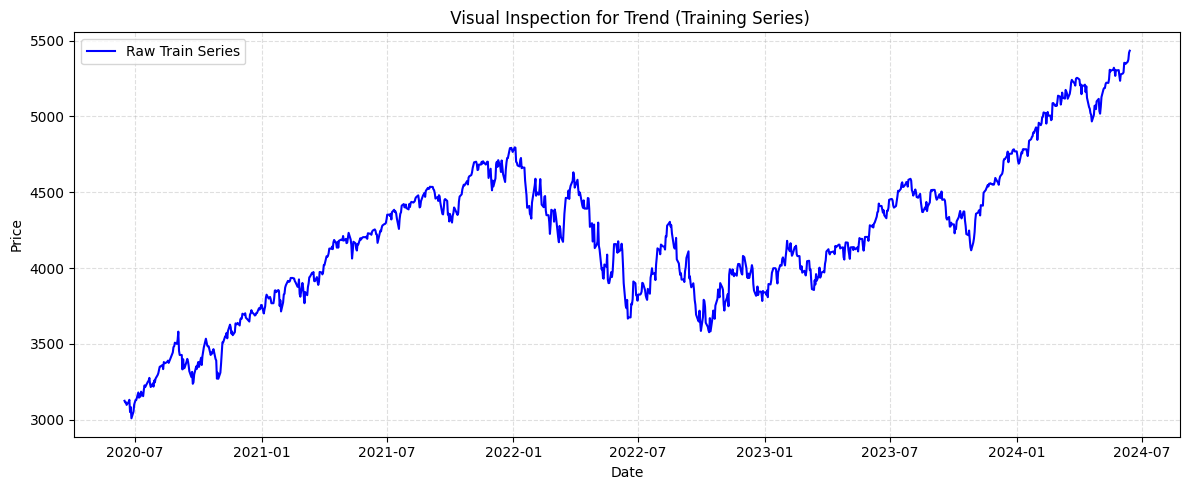

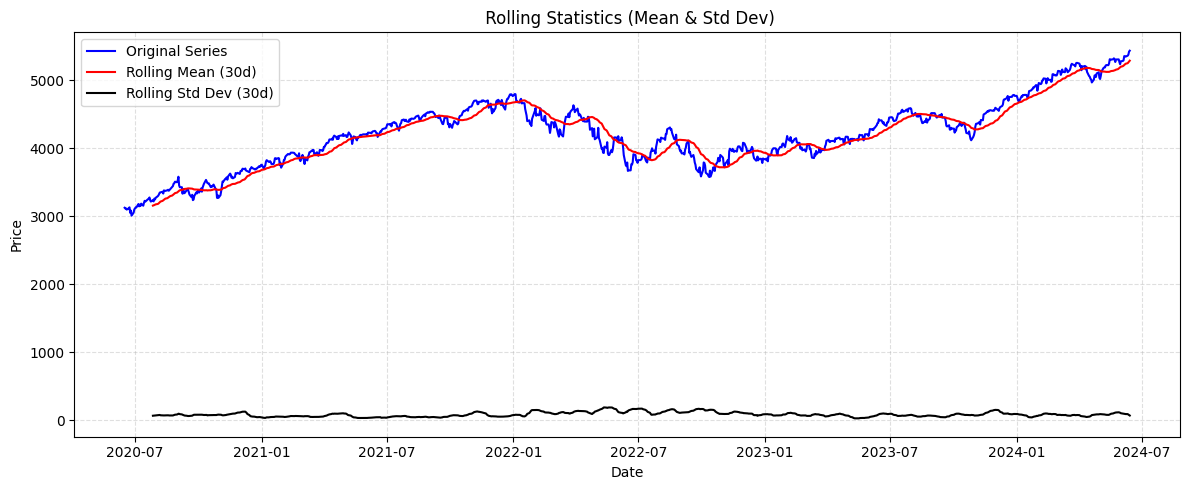

 Augmented Dickey-Fuller Test Results
ADF Statistic : -1.1193
p-value       : 0.7073
Critical Values:
   1% : -3.4367
   5% : -2.8643
   10% : -2.5683
 Likely NON-STATIONARY (Fail to reject H₀)


In [445]:
# ----------------------------------------
# Step 3: Stationarity Check (Training Set)
# ----------------------------------------


# 1. Visual Trend Inspection
plt.figure(figsize=(12, 5))
plt.plot(ts_train_raw, label='Raw Train Series', color='blue')
plt.title(" Visual Inspection for Trend (Training Series)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# 2. Rolling Mean and Std Dev (30-day window)
rolmean = ts_train_raw.rolling(window=30).mean()
rolstd = ts_train_raw.rolling(window=30).std()

plt.figure(figsize=(12, 5))
plt.plot(ts_train_raw, label='Original Series', color='blue')
plt.plot(rolmean, label='Rolling Mean (30d)', color='red')
plt.plot(rolstd, label='Rolling Std Dev (30d)', color='black')
plt.title(" Rolling Statistics (Mean & Std Dev)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# 3. Augmented Dickey-Fuller Test
adf_result = adfuller(ts_train_raw.dropna())
adf_stat, p_value, _, _, critical_values, _ = adf_result

print(" Augmented Dickey-Fuller Test Results")
print(f"ADF Statistic : {adf_stat:.4f}")
print(f"p-value       : {p_value:.4f}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key} : {value:.4f}")

# 4. Interpretation
if p_value <= 0.05:
    print(" Likely STATIONARY (Reject H₀)")
else:
    print(" Likely NON-STATIONARY (Fail to reject H₀)")


The red line (rolling mean) moves noticeably → suggests the mean is not constant → potential trend → non-stationary.

The black line (rolling std dev) is relatively flat → variance is more stable, but not enough alone to confirm stationarity.

 Conclusion: Based on the visual test, the series likely has a trend → it may be non-stationary.

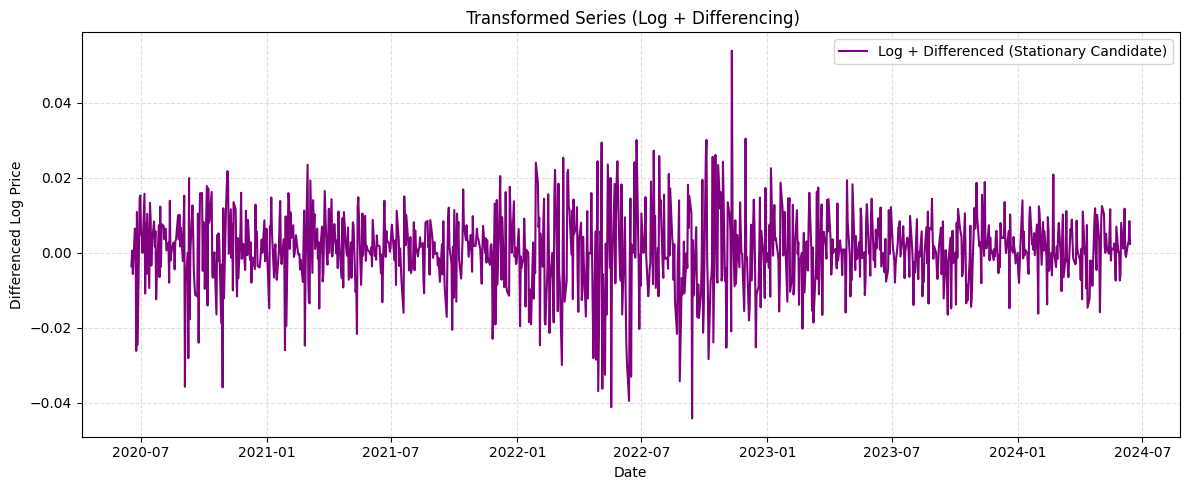

ADF Test on Transformed Series
ADF Statistic : -10.4315
p-value       : 0.0000
Critical Values:
   1% : -3.4367
   5% : -2.8643
   10% : -2.5683
 Stationarity Achieved! Use this for ARIMA/SARIMA


In [446]:
# ----------------------------------------
# Step 4: Make the Series Stationary (Train)
# ----------------------------------------

# 1. Log transformation (to stabilize variance)
ts_train_log = np.log(ts_train_raw)

# 2. First differencing (remove trend)
ts_stationary_train = ts_train_log.diff().dropna()

# Plot the result
plt.figure(figsize=(12, 5))
plt.plot(ts_stationary_train, label='Log + Differenced (Stationary Candidate)', color='purple')
plt.title(" Transformed Series (Log + Differencing)")
plt.xlabel("Date")
plt.ylabel("Differenced Log Price")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# Re-run ADF Test on transformed series
adf_result_trans = adfuller(ts_stationary_train)
adf_stat, p_value, _, _, critical_values, _ = adf_result_trans

print("ADF Test on Transformed Series")
print(f"ADF Statistic : {adf_stat:.4f}")
print(f"p-value       : {p_value:.4f}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key} : {value:.4f}")

if p_value <= 0.05:
    print(" Stationarity Achieved! Use this for ARIMA/SARIMA")
else:
    print(" Still Non-Stationary. Consider higher-order differencing.")


It fluctuates around zero with relatively stable variance and no visible trend.

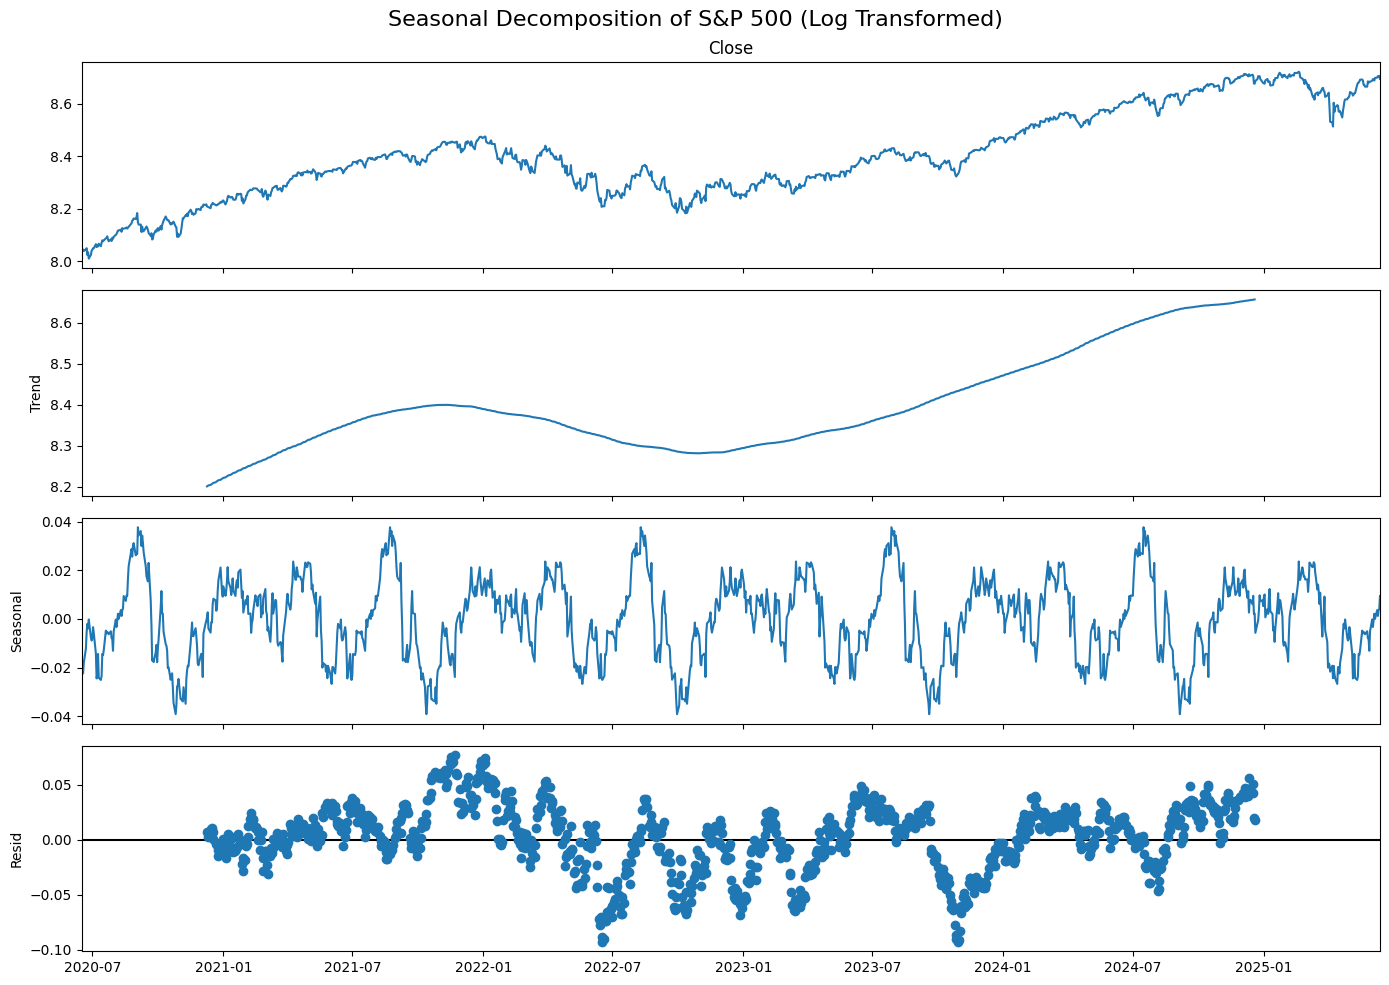


 Component Overview:
• Trend Sample (last 5):
Date
2024-12-13    8.655275
2024-12-16    8.655657
2024-12-17    8.656054
2024-12-18    8.656452
2024-12-19    8.656823
Freq: B, Name: trend, dtype: float64

• Seasonal Sample (unique pattern over a year):
Date
2024-06-27    0.007388
2024-06-28    0.009620
2024-07-01    0.009487
2024-07-02    0.016567
2024-07-03    0.021635
Freq: B, Name: seasonal, dtype: float64

• Residual Sample (last 5):
Date
2024-12-13    0.044852
2024-12-16    0.050123
2024-12-17    0.042393
2024-12-18    0.019496
2024-12-19    0.018054
Freq: B, Name: resid, dtype: float64


In [447]:
# ----------------------------------------
# Step 5: Seasonal Decomposition
# ----------------------------------------

# Apply log transform to full original series (not differenced)
ts_log_full = np.log(ts_raw)

# Decompose the log-transformed series using additive model
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log_full, model='additive', period=252)  # ~1 trading year

# Plot decomposition
fig = decomposition.plot()
fig.set_size_inches(14, 10)
fig.suptitle("Seasonal Decomposition of S&P 500 (Log Transformed)", fontsize=16)
plt.tight_layout()
plt.show()

# Optionally extract the components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Print summary values for interpretation
print("\n Component Overview:")
print(f"• Trend Sample (last 5):\n{trend.dropna().tail()}")
print(f"\n• Seasonal Sample (unique pattern over a year):\n{seasonal[-252:].head()}")
print(f"\n• Residual Sample (last 5):\n{residual.dropna().tail()}")


##  Why ARIMA (Not SARIMA) should be used for Forecasting

After a thorough exploratory analysis and decomposition of the S&P 500 time series, we should proceed with the **ARIMA model** along with other models rather than **SARIMA**. Here's the rationale:

###  Seasonal Decomposition Analysis
Using `seasonal_decompose` with a seasonal period of 252 (approx. 1 trading year), the time series was decomposed into trend, seasonal, and residual components. The results showed:

- **Trend:** A clear long-term upward movement, as expected from a stock index like the S&P 500.
- **Seasonal:** A repeating component was detected but remained **relatively weak in magnitude**, with seasonal values ranging between approximately -0.04 and +0.04.
- **Residuals:** Mostly unstructured, suggesting a clean decomposition.


The weak seasonal component does not significantly dominate or distort the time series. Since ARIMA already handles trend (via differencing) and short-term dependencies, adding a seasonal component (via SARIMA) would introduce additional complexity **without clear benefit**.

### Model Simplicity and Efficiency
- ARIMA is **simpler**, **faster to train**, and **easier to tune** than SARIMA.
- Reducing model complexity is desirable when it does not sacrifice performance.
- The transformed series (log + differenced) passed the stationarity test (ADF), making it suitable for ARIMA modeling.

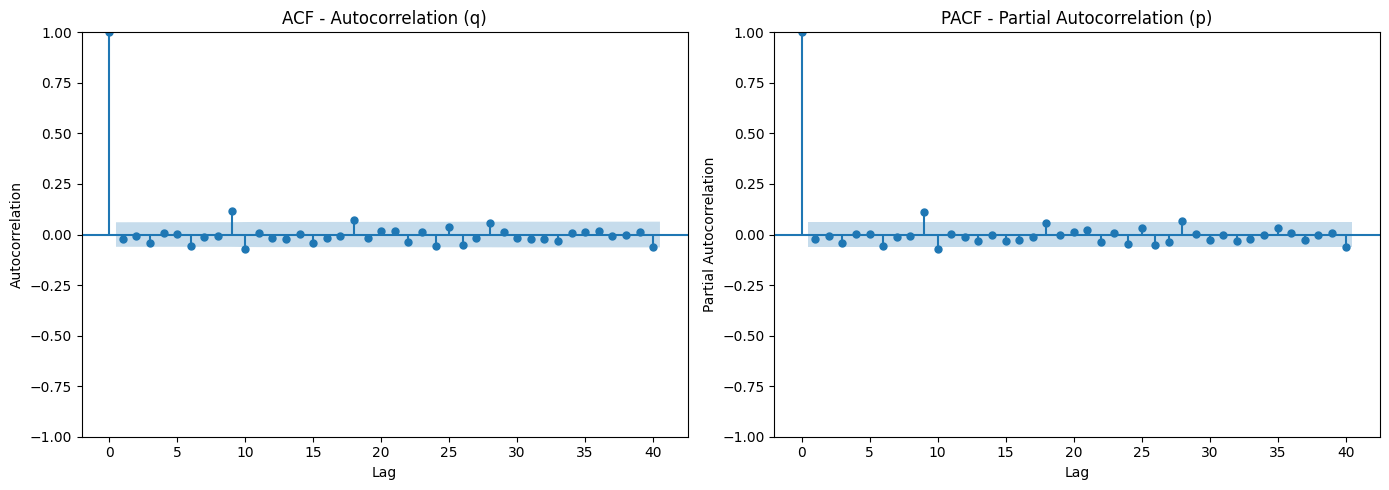

In [448]:
# ----------------------------------------
# Step 6: ACF & PACF (for ARIMA Tuning)
# ----------------------------------------

# Plot ACF and PACF using stationarized training series
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF Plot
plot_acf(ts_stationary_train.dropna(), ax=axes[0], lags=40)
axes[0].set_title("ACF - Autocorrelation (q)")
axes[0].set_xlabel("Lag")
axes[0].set_ylabel("Autocorrelation")

# PACF Plot
plot_pacf(ts_stationary_train.dropna(), ax=axes[1], lags=40, method='ywm')
axes[1].set_title("PACF - Partial Autocorrelation (p)")
axes[1].set_xlabel("Lag")
axes[1].set_ylabel("Partial Autocorrelation")

plt.tight_layout()
plt.show()

## ACF and PACF Interpretation for Time Series Modeling

To understand the internal structure of the time series and guide model design, we examined the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) of the transformed (stationarized) series.

### Purpose

- **ACF (Autocorrelation Function)** measures the correlation between current and lagged values. It helps identify how many past error terms (moving average components) influence the series.
- **PACF (Partial Autocorrelation Function)** measures the direct correlation between current and lagged values, excluding the effects of intermediate lags. It helps identify how many past observations (autoregressive components) contribute significantly.

### Interpretation of the Plots

- The ACF plot showed a significant spike at lag 1, with all subsequent lags falling within the confidence bounds. This indicates a short memory effect from past residuals.
- The PACF plot showed a sharp drop after lag 1, suggesting that only the immediate past value contributes significantly to the current value.

### General Implications

These findings suggest the time series exhibits limited autocorrelation structure beyond the first lag. This informs:

- **Classical models** like ARIMA/SARIMA: indicating low-order models may be sufficient (e.g., ARIMA(1,1,1)).
- **Machine Learning models**: suggesting lag-1 may be a useful input feature, while further lags contribute little additional value.
- **Model diagnostics**: ACF/PACF of residuals can later confirm whether the fitted model adequately captured the time dependence.

This analysis is applicable not only to ARIMA-family models but also provides insight for broader model development and validation across statistical and machine learning approaches in time series forecasting.

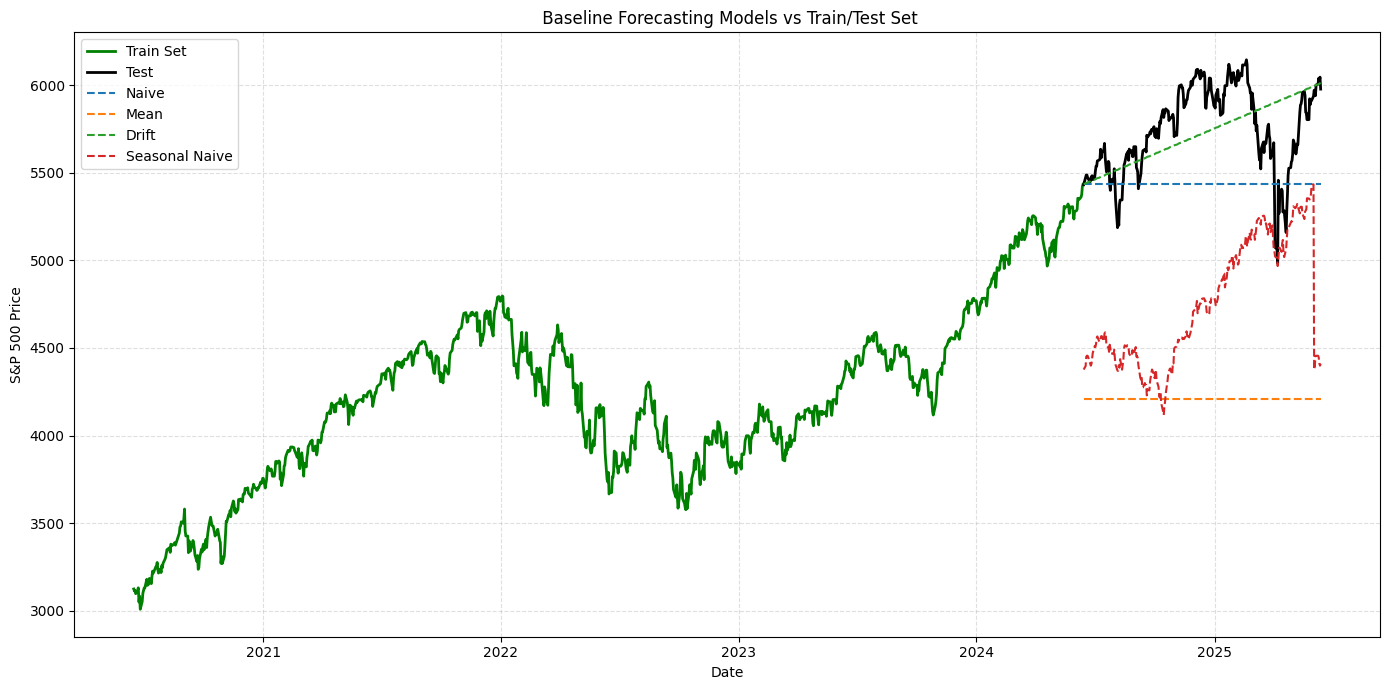

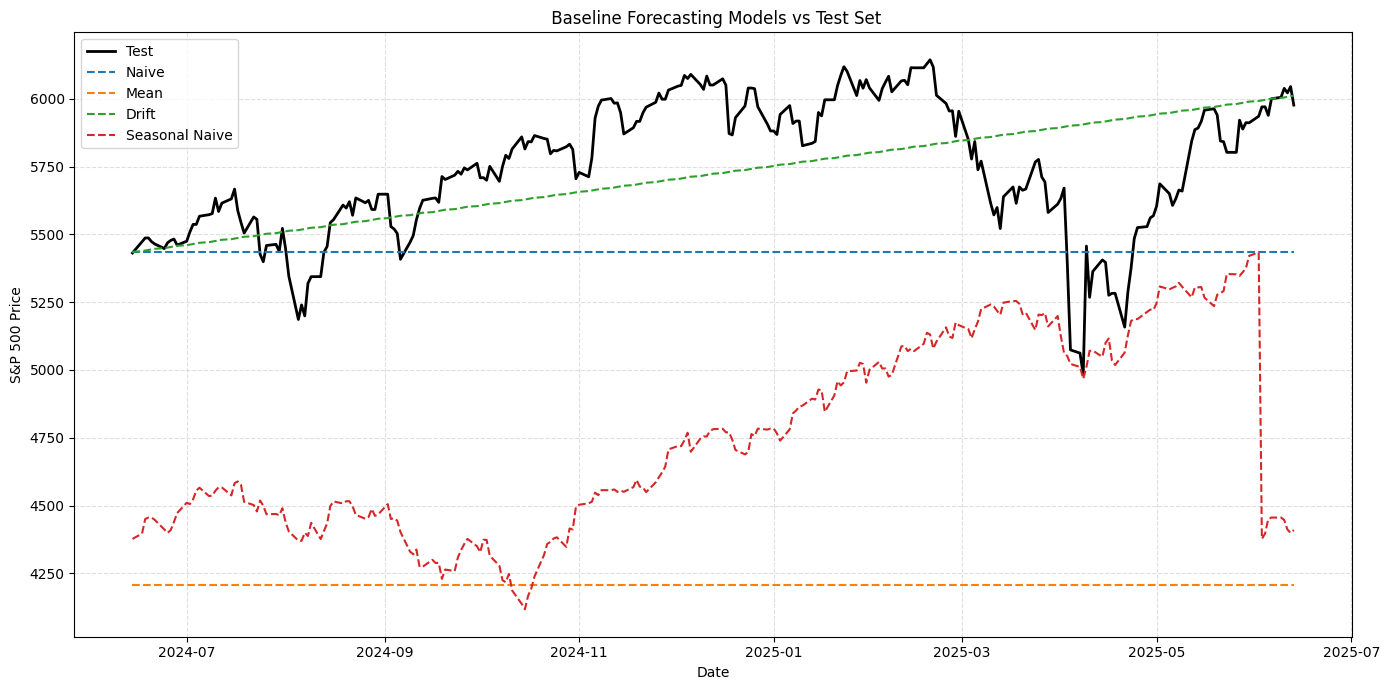


 Use these as benchmarks. If your ARIMA/LSTM/Prophet can't beat these, they may be overkill or under-tuned.


In [ ]:
# ----------------------------------------
# Step 7: Basic Forecasting Models (Benchmarks)
# ----------------------------------------

# Define forecast horizon (length of test set)
n_test = FORECAST_DAYS

# Index for predictions
forecast_index = ts_test_raw.index[:FORECAST_DAYS]

#  Naive Forecast: last observed value
naive_forecast = pd.Series(ts_train_raw.iloc[-1], index=forecast_index)

#  Mean Forecast: average of training set
mean_forecast = pd.Series(ts_train_raw.mean(), index=forecast_index)

#  Drift Forecast: linear increase from start to end of training
drift_slope = (ts_train_raw.iloc[-1] - ts_train_raw.iloc[0]) / (len(ts_train_raw) - 1)
drift_forecast = pd.Series([ts_train_raw.iloc[-1] + i * drift_slope for i in range(1, n_test + 1)], index=forecast_index)

#  Seasonal Naive: reuse values from previous season (wrap if needed)
seasonal_period = 252

if len(ts_train_raw) >= seasonal_period:
    seasonal_values = ts_train_raw[-seasonal_period:].values
    repeats = int(np.ceil(n_test / seasonal_period))
    repeated = np.tile(seasonal_values, repeats)[:n_test]
    seasonal_naive_forecast = pd.Series(repeated, index=forecast_index)
else:
    seasonal_naive_forecast = pd.Series(np.nan, index=forecast_index)


# ----------------------------------------
# Plot all basic forecasts with actual
# ----------------------------------------

plt.figure(figsize=(14, 7))
plt.plot(ts_train_raw, label='Train Set', color='green', linewidth=2)
plt.plot(ts_test_raw, label='Test', linewidth=2, color='black')
plt.plot(naive_forecast, label='Naive', linestyle='--')
plt.plot(mean_forecast, label='Mean', linestyle='--')
plt.plot(drift_forecast, label='Drift', linestyle='--')
plt.plot(seasonal_naive_forecast, label='Seasonal Naive', linestyle='--')

plt.title(" Baseline Forecasting Models vs Train/Test Set - S&P 500")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()



plt.figure(figsize=(14, 7))
plt.plot(ts_test_raw, label='Test', linewidth=2, color='black')
plt.plot(naive_forecast, label='Naive', linestyle='--')
plt.plot(mean_forecast, label='Mean', linestyle='--')
plt.plot(drift_forecast, label='Drift', linestyle='--')
plt.plot(seasonal_naive_forecast, label='Seasonal Naive', linestyle='--')

plt.title(" Baseline Forecasting Models vs Test Set - S&P 500")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()



#  Hint:
print("\n Use these as benchmarks. If your ARIMA/LSTM/Prophet can't beat these, they may be overkill or under-tuned.")


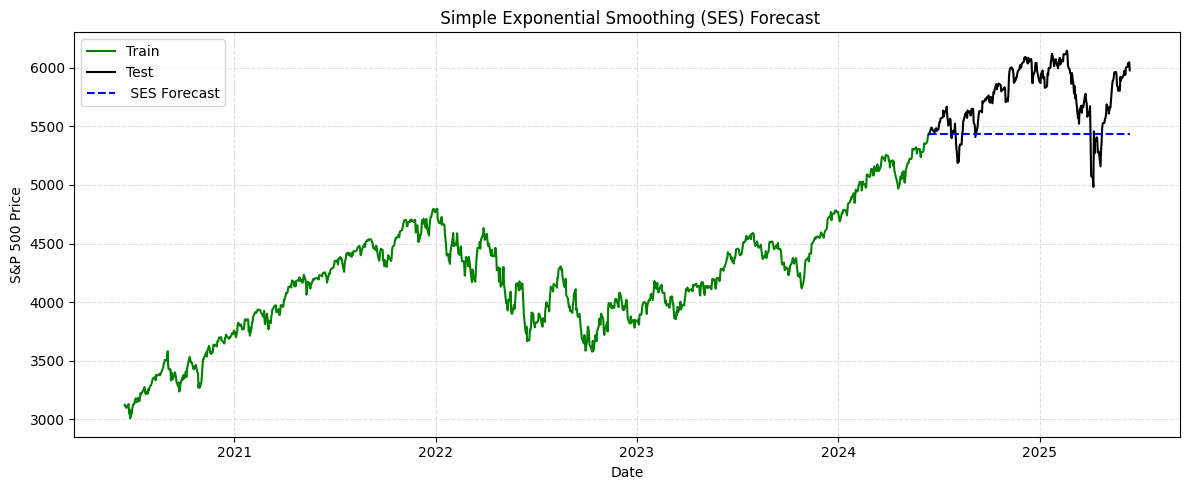


 Last 5 SES Forecasted Values:
2025-06-09    5433.62
2025-06-10    5433.62
2025-06-11    5433.62
2025-06-12    5433.62
2025-06-13    5433.62
Freq: B


In [ ]:
# ----------------------------------------
# Step 8.1: Simple Exponential Smoothing (SES)
# ----------------------------------------


# Fit on training raw data
ses_model = SimpleExpSmoothing(ts_train_raw).fit(optimized=True)

# Forecast for the length of the test set
forecast_ses = ses_model.forecast(FORECAST_DAYS)

# Plot SES forecast
plt.figure(figsize=(12, 5))
plt.plot(ts_train_raw, label='Train', color='green')
plt.plot(ts_test_raw, label='Test', color='black')
plt.plot(forecast_ses, label=' SES Forecast', linestyle='--', color='blue')
plt.title(" Simple Exponential Smoothing (SES) Forecast - S&P 500")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# Text output
print("\n Last 5 SES Forecasted Values:")
print(forecast_ses.tail().round(2).to_string())


SES is expected to perform poorly on trending data like S&P 500 — that’s okay. Its purpose here is benchmarking: it helps you later prove that more complex models (like ARIMA or LSTM) add value.

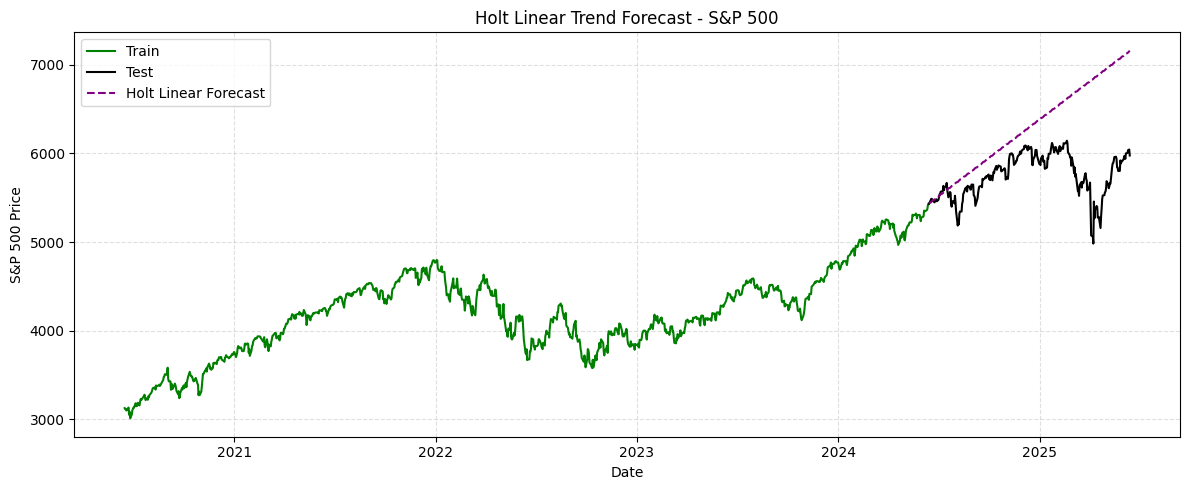


Last 5 Holt Forecasted Values:
2025-06-09    7133.67
2025-06-10    7140.29
2025-06-11    7146.90
2025-06-12    7153.52
2025-06-13    7160.13
Freq: B


In [451]:
# ----------------------------------------
# Step 8.2: Holt’s Linear Trend Method
# ----------------------------------------


# Fit on training raw data
holt_model = Holt(ts_train_raw).fit(optimized=True)

# Forecast
forecast_holt = holt_model.forecast(FORECAST_DAYS)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(ts_train_raw, label='Train', color='green')
plt.plot(ts_test_raw, label='Test', color='black')
plt.plot(forecast_holt, label='Holt Linear Forecast', linestyle='--', color='purple')
plt.title("Holt Linear Trend Forecast - S&P 500")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# Textual Output
print("\nLast 5 Holt Forecasted Values:")
print(forecast_holt.tail().round(2).to_string())


Holt’s method models both level and linear trend, making it more appropriate than SES for trending data like S&P 500. As shown in the plot, the model projects the trend forward linearly.
But note:
It assumes the trend continues at the same rate, which might overshoot in volatile markets. Still, this is an essential and solid benchmark before introducing more complex models.

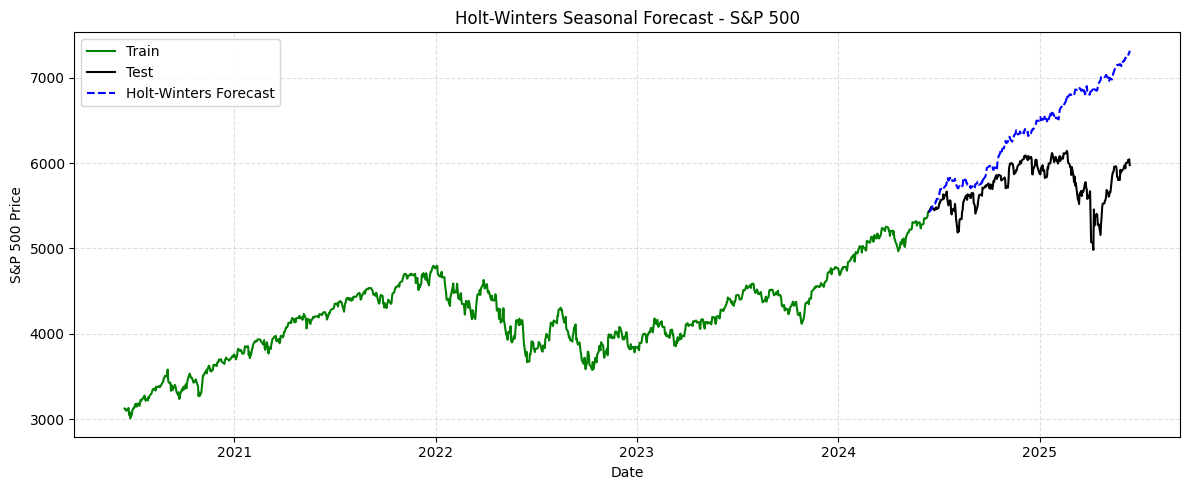


 Last 5 Holt-Winters Forecasted Values:
2025-06-09    7260.95
2025-06-10    7255.12
2025-06-11    7283.76
2025-06-12    7289.13
2025-06-13    7318.04
Freq: B


In [452]:
# ----------------------------------------
# Step 8.3: Holt-Winters Seasonal Method
# ----------------------------------------

# Approximate trading year seasonality
seasonal_period = 252

# Fit Holt-Winters model (additive seasonality, additive trend)
hw_model = ExponentialSmoothing(
    ts_train_raw,
    trend='add',
    seasonal='add',
    seasonal_periods=seasonal_period
).fit(optimized=True)

# Forecast
forecast_hw = hw_model.forecast(FORECAST_DAYS)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(ts_train_raw, label='Train', color='green')
plt.plot(ts_test_raw, label='Test', color='black')
plt.plot(forecast_hw, label='Holt-Winters Forecast', linestyle='--', color='blue')
plt.title("Holt-Winters Seasonal Forecast - S&P 500")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# Textual Output
print("\n Last 5 Holt-Winters Forecasted Values:")
print(forecast_hw.tail().round(2).to_string())


The forecast seems to over-project the trend and shows seasonal jumps that don’t exist in the real test data.
This is expected:
Your seasonal decomposition (from earlier) showed weak seasonality. Holt-Winters is trying to model seasonality where there’s little to none, resulting in overfitting the training pattern.

In [453]:
# ----------------------------------------
# 🔧 Fix: Create log-transformed train/test series
# ----------------------------------------
ts_log_train = np.log(ts_train_raw)
ts_log_test  = np.log(ts_test_raw)


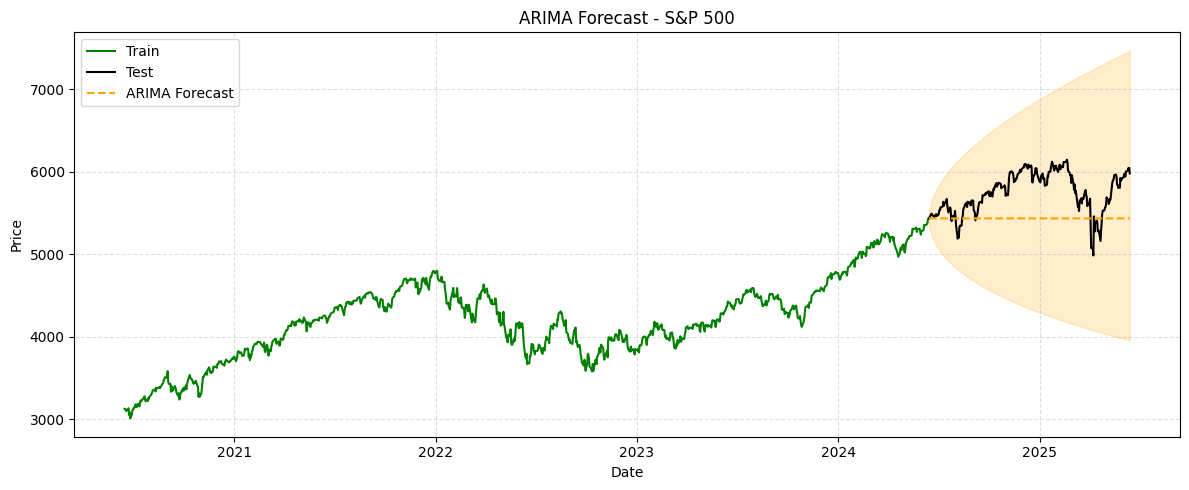


 ARIMA Forecast - Last 5 Days (Original Scale):
2025-06-09    5431.96
2025-06-10    5431.96
2025-06-11    5431.96
2025-06-12    5431.96
2025-06-13    5431.96
Freq: B


In [ ]:
# ----------------------------------------
# Step 9: ARIMA Model (Stationary Branch)
# ----------------------------------------

# Define ARIMA order (can be tuned using ACF/PACF)
p, d, q = 1, 1, 1

# Fit ARIMA model on log-transformed training series
arima_model = ARIMA(ts_log_train, order=(p, d, q))
arima_result = arima_model.fit()

# Forecast in log scale
forecast_log = arima_result.get_forecast(steps=FORECAST_DAYS)
forecast_ci = forecast_log.conf_int()

# Revert to original scale (exp)
forecast_arima = np.exp(forecast_log.predicted_mean)
conf_int_arima = np.exp(forecast_ci)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(ts_train_raw, label='Train', color='green')
plt.plot(ts_test_raw, label='Test', color='black')
plt.plot(forecast_arima, label='ARIMA Forecast', linestyle='--', color='orange')
plt.fill_between(forecast_arima.index, conf_int_arima.iloc[:, 0], conf_int_arima.iloc[:, 1], color='orange', alpha=0.2)
plt.title("ARIMA Forecast - S&P 500")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

#  Text Output
print("\n ARIMA Forecast - Last 5 Days (Original Scale):")
print(forecast_arima.tail().round(2).to_string())


The forecast is flat, which is not necessarily wrong — this reflects ARIMA's limited forward-looking ability after trend removal (differencing).

The confidence interval widens with time — expected behavior, showing increasing uncertainty.

2025-06-15 19:56:22,230 - DEBUG - cmd: where.exe tbb.dll
cwd: None
2025-06-15 19:56:22,295 - DEBUG - TBB already found in load path
2025-06-15 19:56:22,313 - DEBUG - input tempfile: C:\Users\Asus\AppData\Local\Temp\tmpmsmn_b5p\85p4w1fk.json
2025-06-15 19:56:22,364 - DEBUG - input tempfile: C:\Users\Asus\AppData\Local\Temp\tmpmsmn_b5p\i_4tpwsn.json
2025-06-15 19:56:22,366 - DEBUG - idx 0
2025-06-15 19:56:22,366 - DEBUG - running CmdStan, num_threads: None
2025-06-15 19:56:22,367 - DEBUG - CmdStan args: ['D:\\New Programming Projects (Pycharm, VS Code, e.t.c.)\\FoEM\\FoEM\\venv\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=2668', 'data', 'file=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpmsmn_b5p\\85p4w1fk.json', 'init=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpmsmn_b5p\\i_4tpwsn.json', 'output', 'file=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpmsmn_b5p\\prophet_modeltkp9mnv6\\prophet_model-20250615195622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000'


--- Trying changepoint_prior_scale = 0.01 ---


19:56:22 - cmdstanpy - INFO - Chain [1] done processing
2025-06-15 19:56:22,691 - INFO - Chain [1] done processing
2025-06-15 19:56:22,866 - DEBUG - cmd: where.exe tbb.dll
cwd: None
2025-06-15 19:56:22,915 - DEBUG - TBB already found in load path
2025-06-15 19:56:22,929 - DEBUG - input tempfile: C:\Users\Asus\AppData\Local\Temp\tmpmsmn_b5p\zeasw_5p.json
2025-06-15 19:56:22,979 - DEBUG - input tempfile: C:\Users\Asus\AppData\Local\Temp\tmpmsmn_b5p\u9ye75vc.json
2025-06-15 19:56:22,981 - DEBUG - idx 0
2025-06-15 19:56:22,981 - DEBUG - running CmdStan, num_threads: None
2025-06-15 19:56:22,982 - DEBUG - CmdStan args: ['D:\\New Programming Projects (Pycharm, VS Code, e.t.c.)\\FoEM\\FoEM\\venv\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=74362', 'data', 'file=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpmsmn_b5p\\zeasw_5p.json', 'init=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpmsmn_b5p\\u9ye75vc.json', 'output', 'file=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpms


--- Trying changepoint_prior_scale = 0.05 ---


19:56:23 - cmdstanpy - INFO - Chain [1] done processing
2025-06-15 19:56:23,222 - INFO - Chain [1] done processing
2025-06-15 19:56:23,390 - DEBUG - cmd: where.exe tbb.dll
cwd: None
2025-06-15 19:56:23,439 - DEBUG - TBB already found in load path
2025-06-15 19:56:23,450 - DEBUG - input tempfile: C:\Users\Asus\AppData\Local\Temp\tmpmsmn_b5p\j0rng54y.json
2025-06-15 19:56:23,497 - DEBUG - input tempfile: C:\Users\Asus\AppData\Local\Temp\tmpmsmn_b5p\qcrwomz1.json
2025-06-15 19:56:23,502 - DEBUG - idx 0
2025-06-15 19:56:23,502 - DEBUG - running CmdStan, num_threads: None
2025-06-15 19:56:23,503 - DEBUG - CmdStan args: ['D:\\New Programming Projects (Pycharm, VS Code, e.t.c.)\\FoEM\\FoEM\\venv\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=30850', 'data', 'file=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpmsmn_b5p\\j0rng54y.json', 'init=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpmsmn_b5p\\qcrwomz1.json', 'output', 'file=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpms


--- Trying changepoint_prior_scale = 0.1 ---


19:56:23 - cmdstanpy - INFO - Chain [1] done processing
2025-06-15 19:56:23,774 - INFO - Chain [1] done processing
2025-06-15 19:56:23,940 - DEBUG - cmd: where.exe tbb.dll
cwd: None
2025-06-15 19:56:23,988 - DEBUG - TBB already found in load path
2025-06-15 19:56:24,001 - DEBUG - input tempfile: C:\Users\Asus\AppData\Local\Temp\tmpmsmn_b5p\s6a3evpx.json
2025-06-15 19:56:24,048 - DEBUG - input tempfile: C:\Users\Asus\AppData\Local\Temp\tmpmsmn_b5p\4v_btjit.json
2025-06-15 19:56:24,052 - DEBUG - idx 0
2025-06-15 19:56:24,053 - DEBUG - running CmdStan, num_threads: None
2025-06-15 19:56:24,053 - DEBUG - CmdStan args: ['D:\\New Programming Projects (Pycharm, VS Code, e.t.c.)\\FoEM\\FoEM\\venv\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=30752', 'data', 'file=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpmsmn_b5p\\s6a3evpx.json', 'init=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpmsmn_b5p\\4v_btjit.json', 'output', 'file=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpms


--- Trying changepoint_prior_scale = 0.5 ---


19:56:24 - cmdstanpy - INFO - Chain [1] done processing
2025-06-15 19:56:24,516 - INFO - Chain [1] done processing



 Best changepoint_prior_scale: 0.01
MAE: 282.06, RMSE: 379.39, MAPE: 5.01


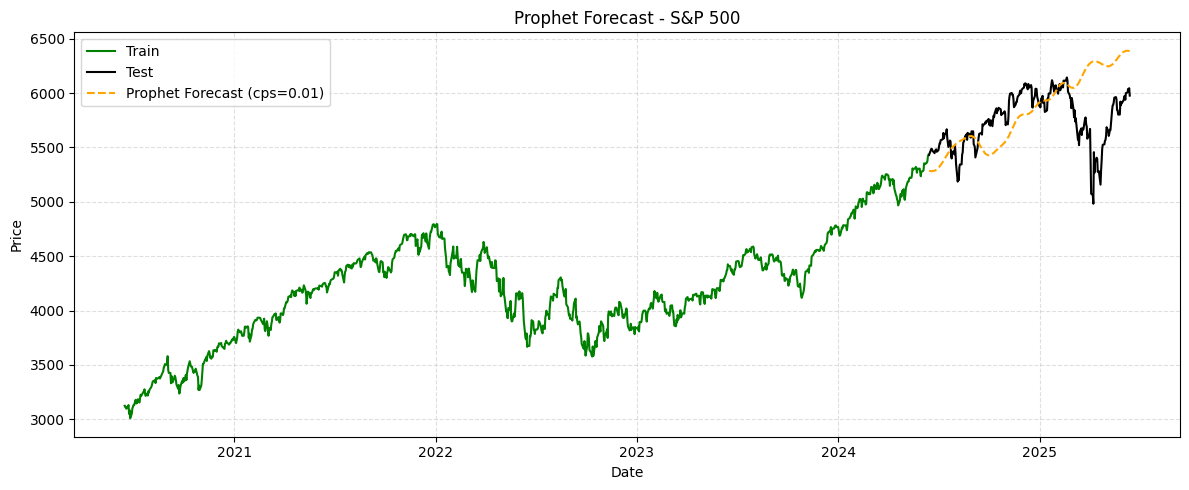

In [ ]:
# ----------------------------------------
# Step 10: Prophet Forecast (Tuned)
# ----------------------------------------

df_prophet = ts_train_raw.reset_index()
df_prophet.columns = ['ds', 'y']

prophet_results = {}

for cps in [0.01, 0.05, 0.1, 0.5]:
    print(f"\n--- Trying changepoint_prior_scale = {cps} ---")
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=cps
    )
    model.fit(df_prophet)

    future = model.make_future_dataframe(periods=FORECAST_DAYS, freq='B')
    forecast = model.predict(future)
    forecast.set_index('ds', inplace=True)

    forecast_index = ts_test_raw.index[:FORECAST_DAYS]
    forecast_prophet_series = forecast['yhat'].reindex(forecast_index)

    # Evaluation
    mae = mean_absolute_error(ts_test_raw[:FORECAST_DAYS], forecast_prophet_series)
    rmse = np.sqrt(mean_squared_error(ts_test_raw[:FORECAST_DAYS], forecast_prophet_series))
    mape = np.mean(np.abs((ts_test_raw[:FORECAST_DAYS] - forecast_prophet_series) / ts_test_raw[:FORECAST_DAYS])) * 100

    prophet_results[cps] = {'mae': mae, 'rmse': rmse, 'mape': mape, 'forecast': forecast_prophet_series}

# Find best by RMSE
best_cps = min(prophet_results, key=lambda x: prophet_results[x]['rmse'])
best_result = prophet_results[best_cps]

print(f"\n Best changepoint_prior_scale: {best_cps}")
print(f"MAE: {best_result['mae']:.2f}, RMSE: {best_result['rmse']:.2f}, MAPE: {best_result['mape']:.2f}")

# Plot best result
plt.figure(figsize=(12, 5))
plt.plot(ts_train_raw, label='Train', color='green')
plt.plot(ts_test_raw, label='Test', color='black')
plt.plot(best_result['forecast'], label=f'Prophet Forecast (cps={best_cps})', linestyle='--', color='orange')
plt.title("Prophet Forecast - S&P 500")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

Prophet captures trend well and offers a flexible, smooth extrapolation.
It sometimes lags behind sudden changes or over-smooths, but that’s expected — Prophet excels in business data with consistent patterns, not extreme volatility.
Compared to your flat ARIMA output, this forecast is more dynamic and likely more useful.

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.1221 - val_loss: 0.0563
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0131 - val_loss: 0.0021
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0087 - val_loss: 0.0025
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0081 - val_loss: 0.0020
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0073 - val_loss: 0.0016
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0061 - val_loss: 0.0029
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0068 - val_loss: 0.0084
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0069 - val_loss: 0.0023
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0046 - val_loss: 0.0011
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0054 - val_loss: 0.0024
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0048 - val_loss: 0.0030
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0

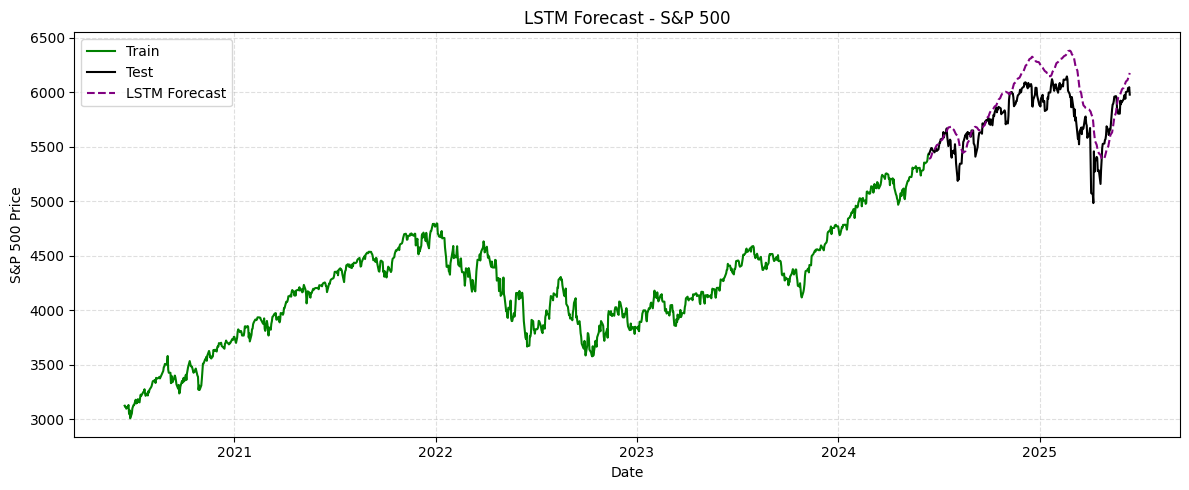


 Improved LSTM Forecast Sample:
Date
2025-06-09    6110.930176
2025-06-10    6125.890137
2025-06-11    6142.490234
2025-06-12    6158.790039
2025-06-13    6175.770020
Freq: B


In [456]:
# ----------------------------------------
# Step 11: Improved LSTM Forecast (Full Test Horizon)
# ----------------------------------------

# Reproducibility
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 1. Normalize only the training data (fit scaler on train only)
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(ts_train_raw.values.reshape(-1, 1))
scaled_test = scaler.transform(ts_test_raw.values.reshape(-1, 1))

# 2. Create sequences
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i])
        y.append(data[i])
    return np.array(X), np.array(y)

lookback = 30
X_train, y_train = create_sequences(scaled_train, lookback)

# 3. Define improved LSTM model
model_lstm = Sequential([
    LSTM(64, return_sequences=True, activation='relu', input_shape=(lookback, 1)),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# 4. Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 5. Train model
model_lstm.fit(X_train, y_train,
               epochs=50,
               batch_size=32,
               validation_split=0.1,
               verbose=1,
               callbacks=[early_stop])

# 6. Forecast using actual test data input (not rolling on own predictions)
X_test_lstm, _ = create_sequences(np.concatenate([scaled_train, scaled_test]), lookback)
X_test_lstm = X_test_lstm[-len(ts_test_raw):]  # Only test period

# Predict
forecast_scaled = model_lstm.predict(X_test_lstm, verbose=0).flatten()

# Inverse transform
forecast_lstm = scaler.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()
forecast_lstm_series = pd.Series(forecast_lstm, index=ts_test_raw.index)


# 7. Plot
plt.figure(figsize=(12, 5))
plt.plot(ts_train_raw, label='Train', color='green')
plt.plot(ts_test_raw, label='Test', color='black')
plt.plot(forecast_lstm_series, label='LSTM Forecast', linestyle='--', color='purple')
plt.title("LSTM Forecast - S&P 500")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# 9. Output sample
print("\n Improved LSTM Forecast Sample:")
print(forecast_lstm_series.tail().round(2).to_string())


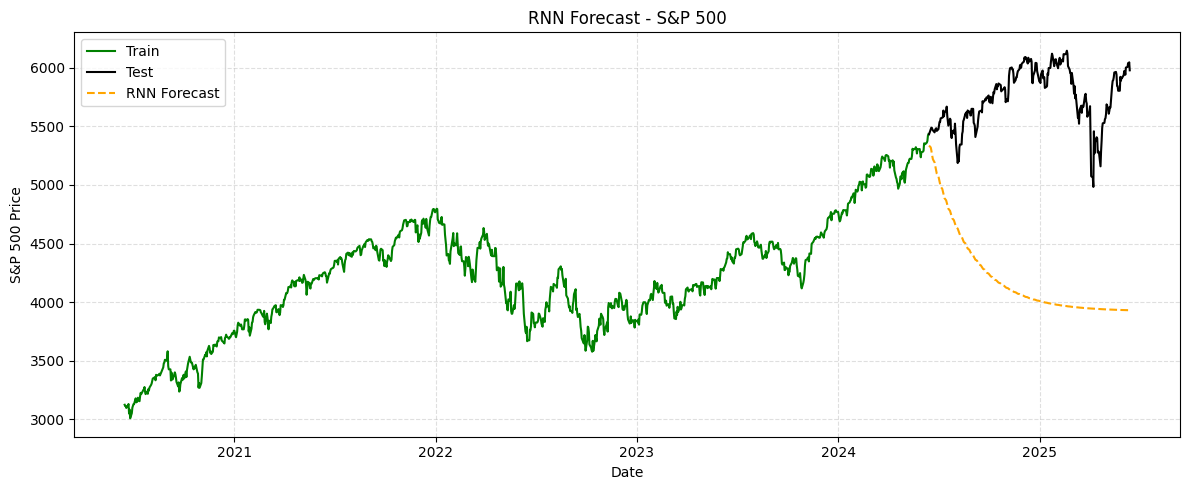


 RNN Forecast Sample (last 5):
Date
2025-06-09    3931.649902
2025-06-10    3931.469971
2025-06-11    3931.290039
2025-06-12    3931.110107
2025-06-13    3930.939941
Freq: B


In [457]:
# ----------------------------------------
# Step 12: RNN Forecast (Raw Series)
# ----------------------------------------

# Set seed for reproducibility
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Reuse same window size and scaled_train
window_size = 30
n_features = 1

# Create training sequences for RNN
def create_rnn_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X_rnn, y_rnn = create_rnn_sequences(scaled_train, window_size)

# Build simple RNN model
rnn_model = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(window_size, n_features)),
    Dropout(0.2),
    Dense(1)
])
rnn_model.compile(optimizer='adam', loss='mse')

# Train
rnn_model.fit(X_rnn, y_rnn, epochs=30, batch_size=32, verbose=0)

# Forecast next len(test) steps
forecast_horizon = FORECAST_DAYS
input_seq = scaled_train[-window_size:].reshape(1, window_size, 1)
forecast_scaled = []

for _ in range(forecast_horizon):
    pred = rnn_model.predict(input_seq, verbose=0)[0, 0]
    forecast_scaled.append(pred)
    input_seq = np.append(input_seq[:, 1:, :], [[[pred]]], axis=1)

# Reverse scale
forecast_rnn = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()
rnn_forecast_series = pd.Series(forecast_rnn, index=ts_test_raw.index[:FORECAST_DAYS])

# Plot
plt.figure(figsize=(12, 5))
plt.plot(ts_train_raw, label="Train", color='green')
plt.plot(ts_test_raw, label="Test", color='black')
plt.plot(rnn_forecast_series, label="RNN Forecast", linestyle='--', color='orange')
plt.title("RNN Forecast - S&P 500")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# Output sample
print("\n RNN Forecast Sample (last 5):")
print(rnn_forecast_series.tail().round(2).to_string())

The forecast declines unnaturally — a typical symptom of RNNs trained on univariate data without sufficient complexity or regularization. Like your LSTM, it likely overfits the last downward movements, then compounds prediction drift during recursive rollout. The problem is not the pipeline, but the model capacity and signal context.

In [458]:
# ----------------------------------------
# Step 13: Evaluation - MAE, RMSE, MAPE
# ----------------------------------------

eval_results = {}

def evaluate_model(true, pred, label):
    # Align length automatically if needed
    min_len = min(len(true), len(pred))
    true, pred = true[:min_len], pred[:min_len]
    
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape = np.mean(np.abs((true - pred) / true)) * 100
    eval_results[label] = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# Run evaluations
evaluate_model(ts_test_raw, naive_forecast, "Naive")
evaluate_model(ts_test_raw, seasonal_naive_forecast, "Seasonal Naive")
evaluate_model(ts_test_raw, drift_forecast, "Drift")
evaluate_model(ts_test_raw, mean_forecast, "Mean")

evaluate_model(ts_test_raw, forecast_ses, "SES")
evaluate_model(ts_test_raw, forecast_holt, "Holt Linear")
evaluate_model(ts_test_raw, forecast_hw, "Holt-Winters")

evaluate_model(ts_test_raw, forecast_arima, "ARIMA")
evaluate_model(ts_test_raw, prophet_results[best_cps]['forecast'], f"Prophet")
evaluate_model(ts_test_raw, forecast_lstm_series, "LSTM")
evaluate_model(ts_test_raw, rnn_forecast_series, "RNN")

# Convert to DataFrame
eval_df = pd.DataFrame(eval_results).T.round(2)
eval_df = eval_df.sort_values(by="RMSE")  # Sort by RMSE

# Show tables
print("Model Evaluation Metrics:")
display(eval_df)

print("\nSorted by MAE:")
display(eval_df.sort_values(by="MAE"))

print("\nSorted by MAPE:")
display(eval_df.sort_values(by="MAPE"))

Model Evaluation Metrics:


,MAE,RMSE,MAPE
LSTM,176.55,224.67,3.08
Drift,193.43,249.30,3.40
Prophet,282.06,379.39,5.01
Naive,339.29,396.58,5.78
SES,339.39,396.68,5.78
ARIMA,340.73,397.99,5.81
Holt Linear,558.08,733.28,9.80
Holt-Winters,623.15,790.28,10.92
Seasonal Naive,998.47,1073.79,17.26
Mean,1538.75,1558.14,26.65



Sorted by MAE:


,MAE,RMSE,MAPE
LSTM,176.55,224.67,3.08
Drift,193.43,249.30,3.40
Prophet,282.06,379.39,5.01
Naive,339.29,396.58,5.78
SES,339.39,396.68,5.78
ARIMA,340.73,397.99,5.81
Holt Linear,558.08,733.28,9.80
Holt-Winters,623.15,790.28,10.92
Seasonal Naive,998.47,1073.79,17.26
Mean,1538.75,1558.14,26.65



Sorted by MAPE:


,MAE,RMSE,MAPE
LSTM,176.55,224.67,3.08
Drift,193.43,249.30,3.40
Prophet,282.06,379.39,5.01
Naive,339.29,396.58,5.78
SES,339.39,396.68,5.78
ARIMA,340.73,397.99,5.81
Holt Linear,558.08,733.28,9.80
Holt-Winters,623.15,790.28,10.92
Seasonal Naive,998.47,1073.79,17.26
RNN,1543.55,1628.78,26.60


📌 Lower RMSE and MAE values indicate better performance.  
MAPE (%) gives a relative error percentage — useful for comparing across models.  
The best models are typically those with lowest RMSE and reasonable MAPE.

### Step 15: Comparing models

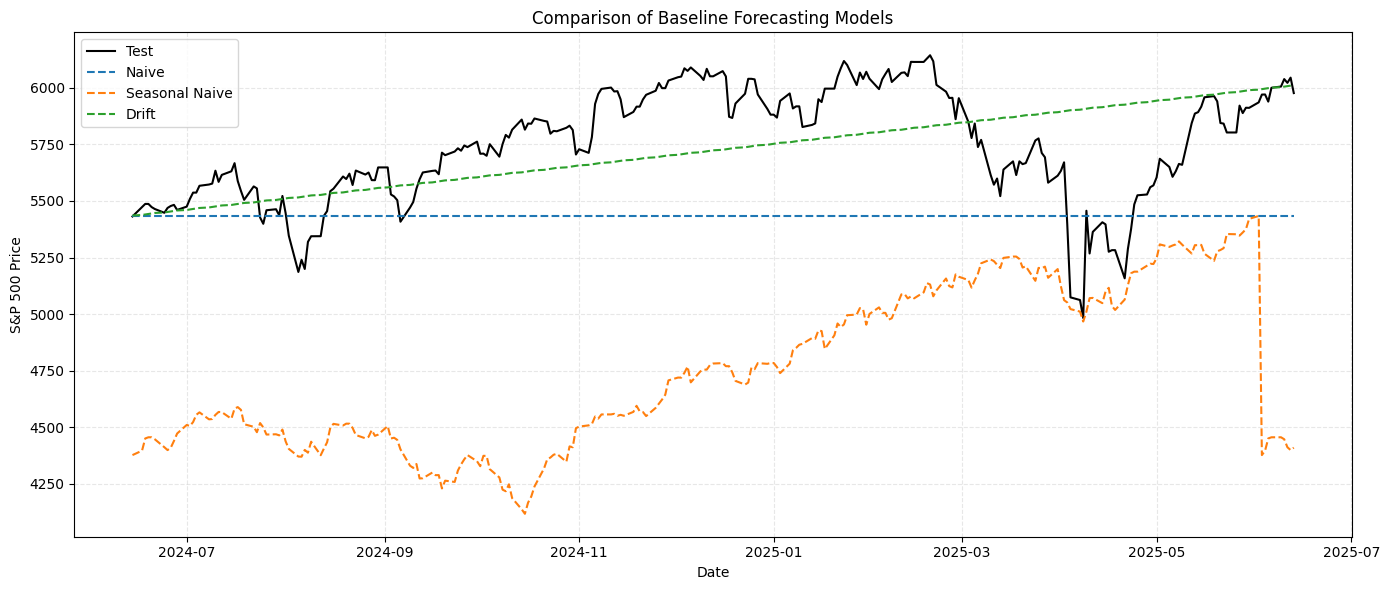

In [459]:
plt.figure(figsize=(14, 6))
plt.plot(ts_test_raw, label="Test", color="black")
plt.plot(naive_forecast, label="Naive", linestyle='--')
plt.plot(seasonal_naive_forecast, label="Seasonal Naive", linestyle='--')
plt.plot(drift_forecast, label="Drift", linestyle='--')
plt.title("Comparison of Baseline Forecasting Models")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

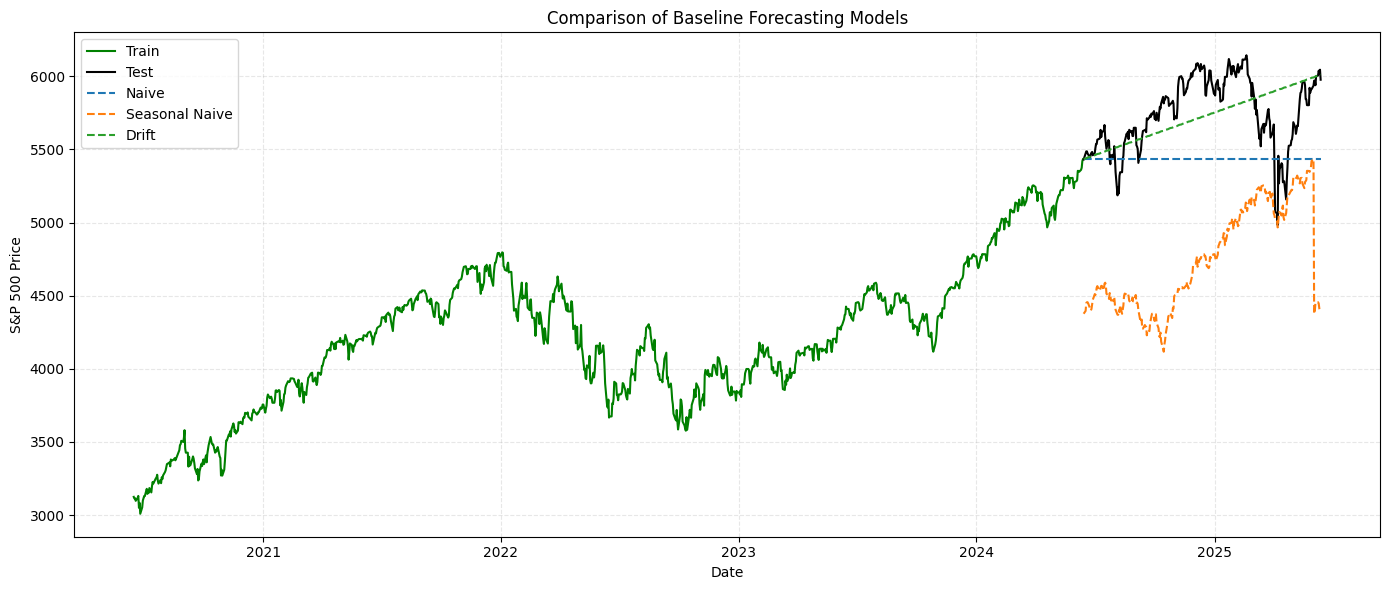

In [460]:
plt.figure(figsize=(14, 6))
plt.plot(ts_train_raw, label="Train", color="green")
plt.plot(ts_test_raw, label="Test", color="black")
plt.plot(naive_forecast, label="Naive", linestyle='--')
plt.plot(seasonal_naive_forecast, label="Seasonal Naive", linestyle='--')
plt.plot(drift_forecast, label="Drift", linestyle='--')
plt.title("Comparison of Baseline Forecasting Models")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

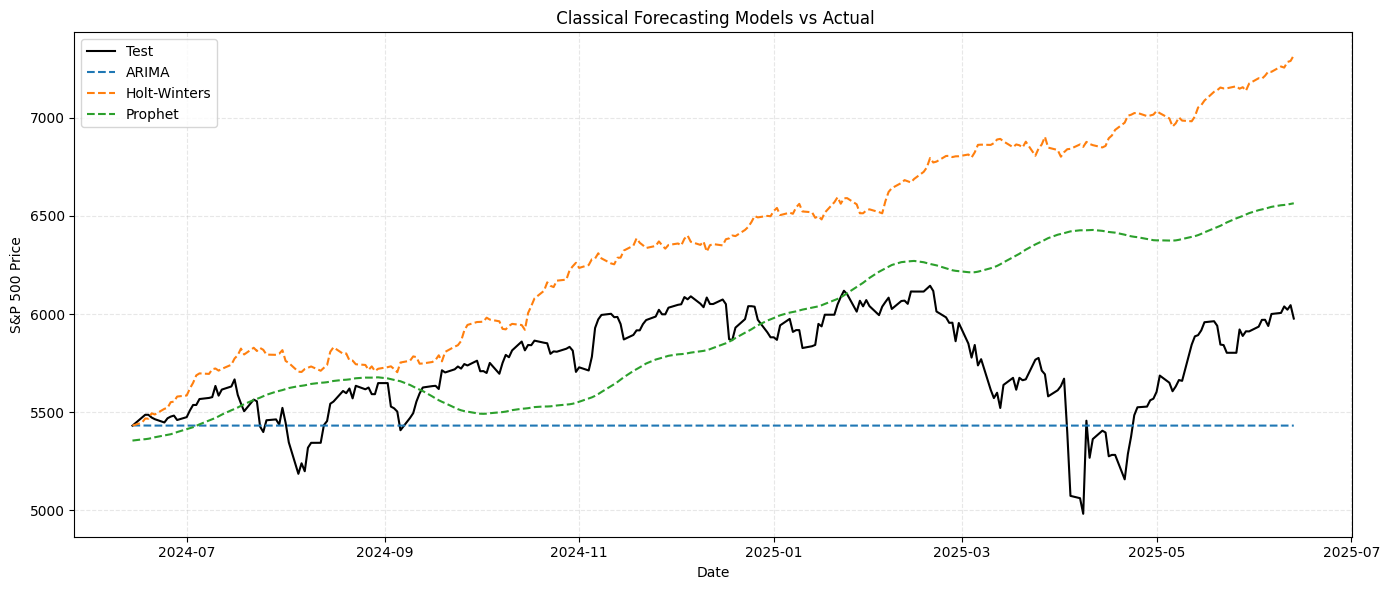

In [461]:
plt.figure(figsize=(14, 6))
plt.plot(ts_test_raw, label="Test", color="black")
plt.plot(forecast_arima, label="ARIMA", linestyle='--')
plt.plot(forecast_hw, label="Holt-Winters", linestyle='--')
plt.plot(forecast_prophet_series, label="Prophet", linestyle='--')
plt.title(" Classical Forecasting Models vs Actual")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

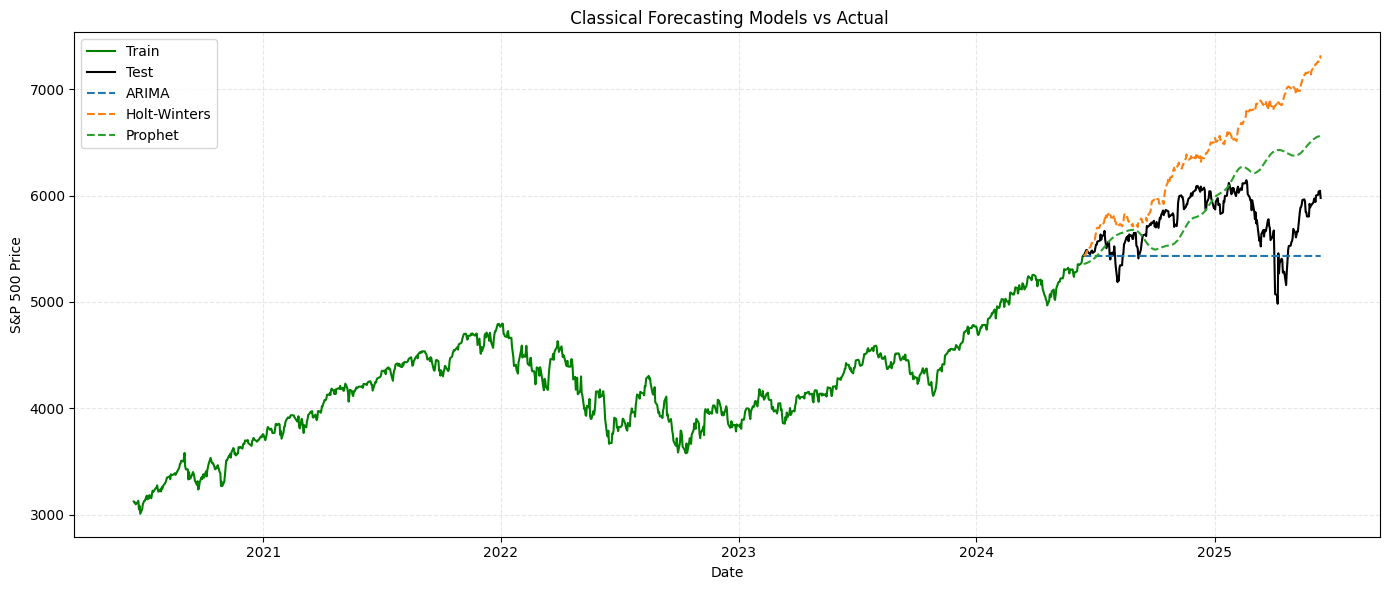

In [462]:
plt.figure(figsize=(14, 6))
plt.plot(ts_train_raw, label="Train", color="green")
plt.plot(ts_test_raw, label="Test", color="black")
plt.plot(forecast_arima, label="ARIMA", linestyle='--')
plt.plot(forecast_hw, label="Holt-Winters", linestyle='--')
plt.plot(forecast_prophet_series, label="Prophet", linestyle='--')
plt.title(" Classical Forecasting Models vs Actual")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

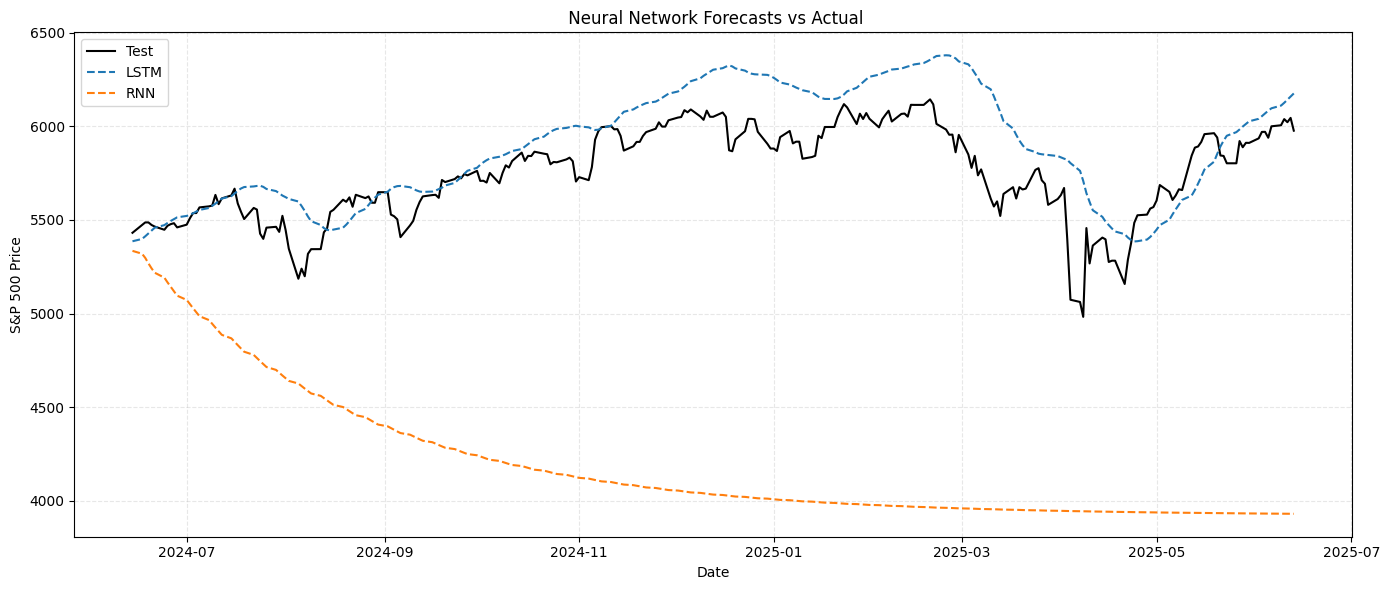

In [463]:
plt.figure(figsize=(14, 6))
plt.plot(ts_test_raw, label="Test", color="black")
plt.plot(forecast_lstm_series, label="LSTM", linestyle='--')
plt.plot(rnn_forecast_series, label="RNN", linestyle='--')
plt.title(" Neural Network Forecasts vs Actual")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

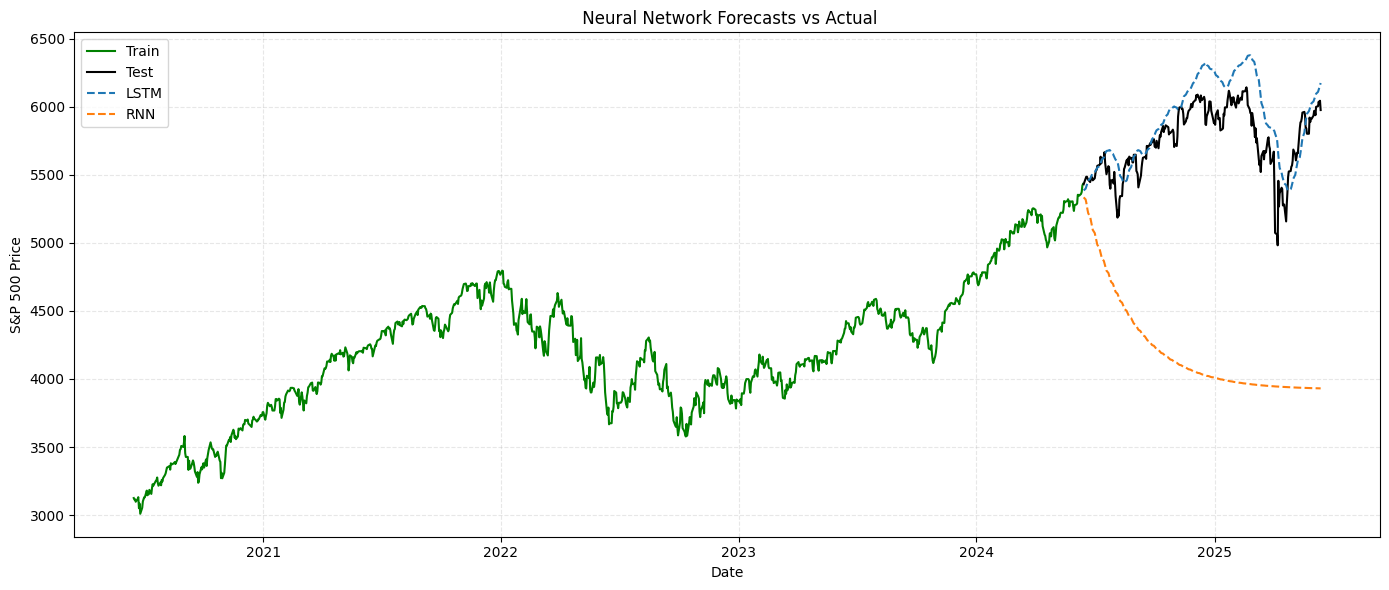

In [464]:
plt.figure(figsize=(14, 6))
plt.plot(ts_train_raw, label="Train", color="green")
plt.plot(ts_test_raw, label="Test", color="black")
plt.plot(forecast_lstm_series, label="LSTM", linestyle='--')
plt.plot(rnn_forecast_series, label="RNN", linestyle='--')
plt.title(" Neural Network Forecasts vs Actual")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

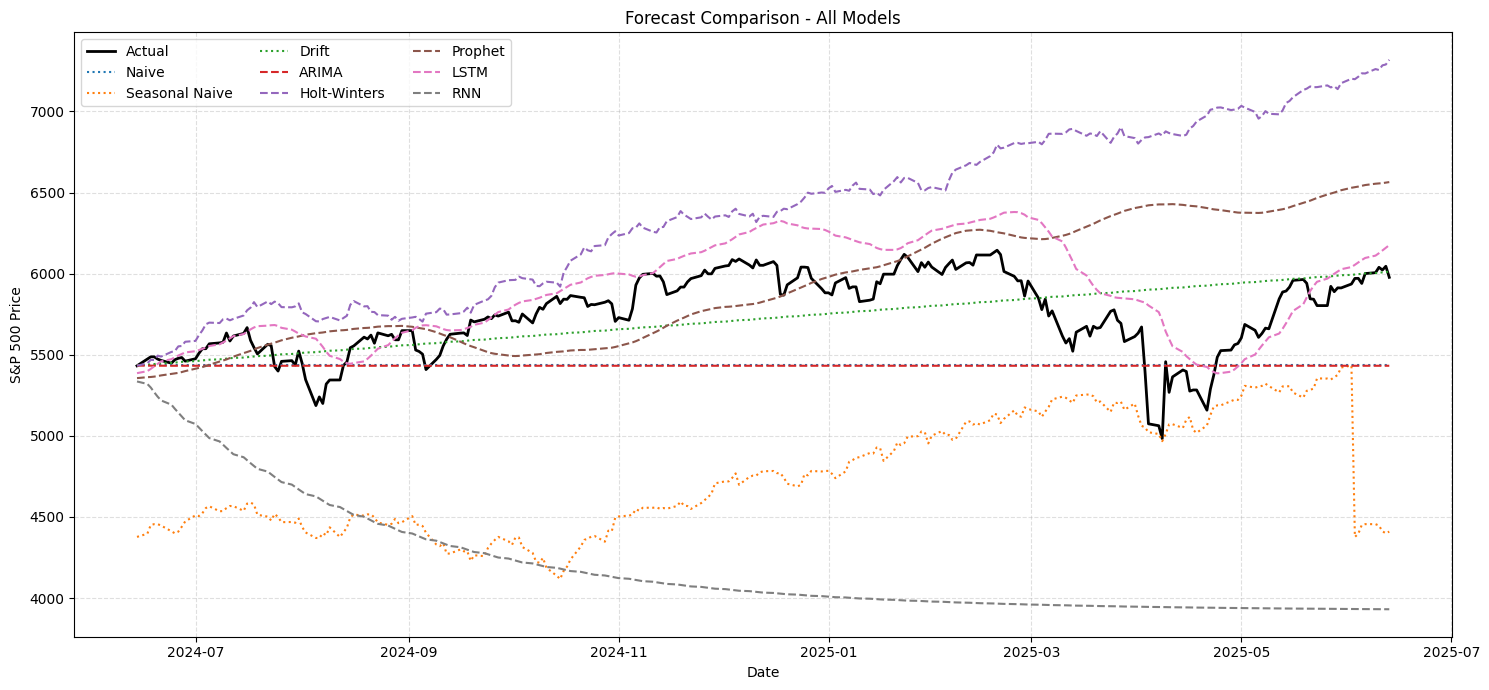

In [465]:
plt.figure(figsize=(15, 7))

plt.plot(ts_test_raw, label="Actual", color="black", linewidth=2)
plt.plot(naive_forecast, label="Naive", linestyle=':')
plt.plot(seasonal_naive_forecast, label="Seasonal Naive", linestyle=':')
plt.plot(drift_forecast, label="Drift", linestyle=':')
plt.plot(forecast_arima, label="ARIMA", linestyle='--')
plt.plot(forecast_hw, label="Holt-Winters", linestyle='--')
plt.plot(forecast_prophet_series, label="Prophet", linestyle='--')
plt.plot(forecast_lstm_series, label="LSTM", linestyle='--')
plt.plot(rnn_forecast_series, label="RNN", linestyle='--')
plt.title("Forecast Comparison - All Models")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend(ncol=3)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

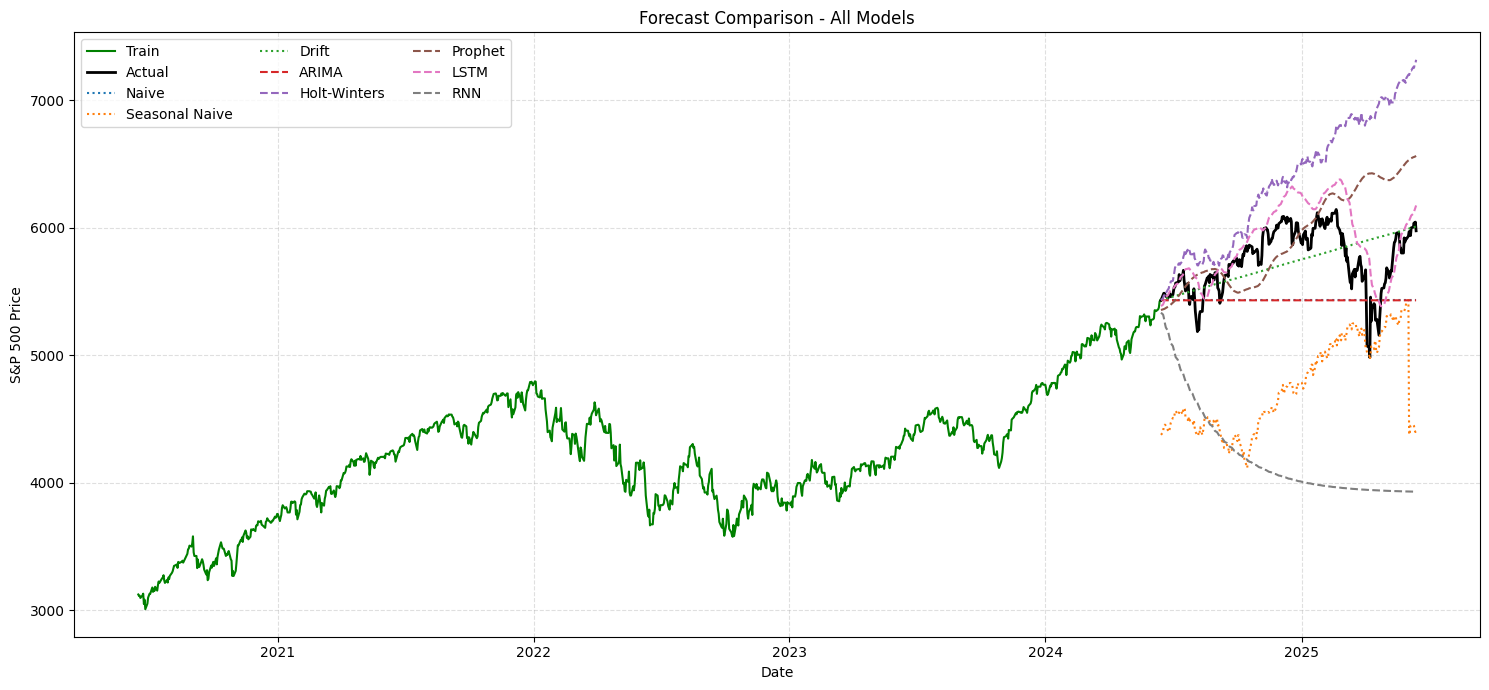

In [466]:
plt.figure(figsize=(15, 7))
plt.plot(ts_train_raw, label="Train", color="green")
plt.plot(ts_test_raw, label="Actual", color="black", linewidth=2)
plt.plot(naive_forecast, label="Naive", linestyle=':')
plt.plot(seasonal_naive_forecast, label="Seasonal Naive", linestyle=':')
plt.plot(drift_forecast, label="Drift", linestyle=':')
plt.plot(forecast_arima, label="ARIMA", linestyle='--')
plt.plot(forecast_hw, label="Holt-Winters", linestyle='--')
plt.plot(forecast_prophet_series, label="Prophet", linestyle='--')
plt.plot(forecast_lstm_series, label="LSTM", linestyle='--')
plt.plot(rnn_forecast_series, label="RNN", linestyle='--')
plt.title("Forecast Comparison - All Models")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend(ncol=3)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()